Deep Learning Vehicle Tracking: Starter code
======

This demo shows how to approach Vehicle Tracking with deep learing.
Using the data from udacitys "Vehicle Detection and Tracking" project. 
The images provided (car and non car) shoulb be placed in ./vehicles/ and ./non-vehicles/

In [1]:
import glob 
import cv2
import numpy as np
import skimage
from skimage import data, color, exposure

In [2]:
cars = glob.glob("./vehicles/*/*.png")
non_cars = glob.glob("./non-vehicles/*/*.png")

# Generate Y Vector
Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))-1])

# Read X Vector
X = []
for name in cars:    
    X.append(skimage.io.imread(name))
for name in non_cars:    
    X.append(skimage.io.imread(name))
X = np.array(X)

### After loading I do the usual pre-processing

I do not use a validation split, but I have to validate that the model works well in localization independently anyway.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
input_shape =  (3,64,64)

X_train shape: (16612, 64, 64, 3)
16612 train samples
1846 test samples


### Define Keras model in Classification mode

In the model definition I do not use any dense layers, but analogous Convolution2D layers. Also, since I do not have classes, but -1 and 1, I use the mse metric for loss. Adding more than two classes is a bit more tricky because softmax needs normalization along the correct axis (see bottom).

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Lambda
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K


def get_conv(input_shape=(64,64,3), filename=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv1',input_shape=input_shape, border_mode="same"))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv2',border_mode="same"))
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.25))
    model.add(Convolution2D(128,8,8,activation="relu",name="dense1")) # This was Dense(128)
    model.add(Dropout(0.5))
    model.add(Convolution2D(1,1,1,name="dense2", activation="tanh")) # This was Dense(1)
    if filename:
        model.load_weights(filename)        
    return model

model = get_conv()
model.add(Flatten())
model.compile(loss='mse',optimizer='adadelta',metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=128, nb_epoch=20, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
model.save_weights("localize.h5")

Using TensorFlow backend.


Train on 16612 samples, validate on 1846 samples
Epoch 1/20
16612/16612 [==============================] - 4s - loss: 0.5782 - acc: 0.4325 - val_loss: 0.2845 - val_acc: 0.8061
Epoch 2/20
16612/16612 [==============================] - 4s - loss: 0.2131 - acc: 0.8340 - val_loss: 0.1268 - val_acc: 0.8944
Epoch 3/20
16612/16612 [==============================] - 4s - loss: 0.1256 - acc: 0.9056 - val_loss: 0.0808 - val_acc: 0.9388
Epoch 4/20
16612/16612 [==============================] - 4s - loss: 0.0987 - acc: 0.9278 - val_loss: 0.0767 - val_acc: 0.9475
Epoch 5/20
16612/16612 [==============================] - 4s - loss: 0.0801 - acc: 0.9423 - val_loss: 0.0578 - val_acc: 0.9588
Epoch 6/20
16612/16612 [==============================] - 4s - loss: 0.0713 - acc: 0.9480 - val_loss: 0.0663 - val_acc: 0.9507
Epoch 7/20
16612/16612 [==============================] - 4s - loss: 0.0629 - acc: 0.9529 - val_loss: 0.0527 - val_acc: 0.9653
Epoch 8/20
16612/16612 [==============================] - 4s -

# Turn the classifier into a heat map
Now this is the fun part: since the model is all Conv2d I do not actually specify image dimensions (although that is useful for training). And I do not add the flatten() layer in the end

In [5]:
heatmodel = get_conv(input_shape=(None,None,3), filename="localize.h5")
# that is it!

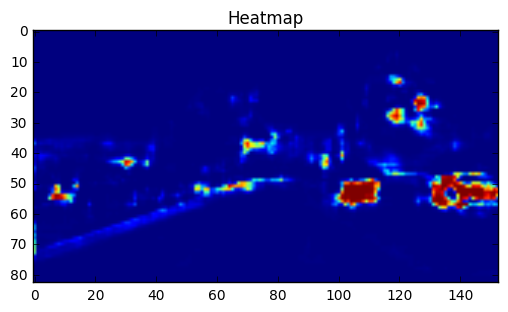

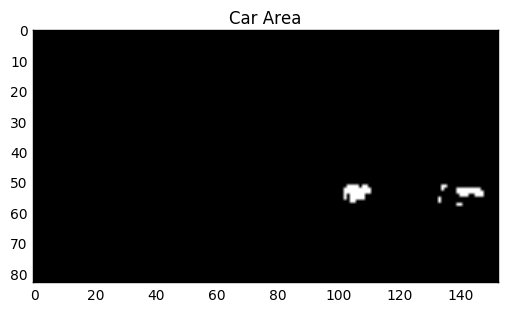

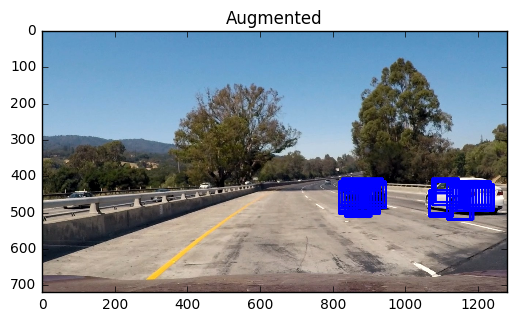

In [6]:
%matplotlib inline
import matplotlib.pylab as plt

def locate():
    data = (skimage.io.imread("test1.jpg"))
    
    heatmap = heatmodel.predict(data.reshape(1,data.shape[0],data.shape[1],data.shape[2]))
    
    plt.imshow(heatmap[0,:,:,0])
    plt.title("Heatmap")
    plt.show()
    plt.imshow(heatmap[0,:,:,0]>0.99, cmap="gray")
    plt.title("Car Area")
    plt.show()

    xx, yy = np.meshgrid(np.arange(heatmap.shape[2]),np.arange(heatmap.shape[1]))
    x = (xx[heatmap[0,:,:,0]>0.99])
    y = (yy[heatmap[0,:,:,0]>0.99])
    
    for i,j in zip(x,y):
        cv2.rectangle(data, (i*8,j*8), (i*8+64,j*8+64), (0,0,255), 5)
    return data

annotated = locate()

plt.title("Augmented")    
plt.imshow(annotated)
plt.show()

### What else is there to do

- Lower false positives further. As you can see from the heatmap parts of the tree are a bit dangerous you could consider grabbing a few patches there saving them and adding them to the non-vehicle data

- If you try to run this model on an car image that is way larger than 64x64 pixels you will get funny results. Therefore you will need scaling or region proposals to really catch all possible. But the good news is that a scaling factor of 2 is usually okay (as you can see the cars in the demo image are also to big but detected just fine.

- Optimize for speed by only using sensible image areas sizes.

- Make one box per car. This is not a deep learning task but still necessary.

### More than two classes

For more than two classes you need the softmax classifier the way it is currently implemented in keras only works in flat arrays. However there is a github project with uses Alexnet, Resnet etc to generate heatmaps in the same style and they also implemented a "Softmax4D" layer. You can check it here https://github.com/heuritech/convnets-keras (very interesting read). Using this our model becomes (something like this). 

In [ ]:
# You need to adapt the Y vector to be [0,1] and [1,0] instead of -1 or -1 for this to work
from customlayers import Softmax4D

def get_conv(input_shape=(64,64,3), filename=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    model.add(Convolution2D(20, 3, 3, activation='relu', name='conv1',input_shape=input_shape, border_mode="same"))
    model.add(Convolution2D(20, 3, 3, activation='relu', name='conv2',border_mode="same"))
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.25))
    model.add(Convolution2D(128,8,8,activation="relu",name="dense1"))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2,1,1,name="dense2"))
    model.add(Softmax4D(axis=3,name="softmax"))
    return model

model = get_conv()
model.add(Flatten())
model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

This was actually the first version of I made, tanh is much more easy to understand the basic principle.

### Contribute

If you have Ideas on how to improve and make this notebook more easy to understand feel free to send me a pull request. Also feel free to add features!

Henrik Tünnermann 